In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

### Physical parameters

In [2]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

### Load dataset

In [3]:
data_dir = "../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
print(f"Δt = {(ds['time'][-1] - ds['time'][0]).values*1e-9/(24*60*60)} days")
ds = ds.mean('time')
ds, grid = add_rotated_coords(ds, θ)
ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

Δt = 400 days


In [4]:
ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C')
ds['Nsq'] = -g/ρ0*ds['DRHODR'].where(ds['DRHODR']!=0.)+g*α*Γ
ds['Nsq_hab'] = hab_interp(ds['Nsq'], vert_coord='Zl')
ds['Nsq_hab_av'] = ds['Nsq_hab'].mean(['XC', 'YC'], skipna=True).compute()

In [5]:
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')
ds['THETA_BG_hab'] = hab_interp(ds['THETA_BG'], vert_coord='Z')

### Load bathymetry and hydrography

In [6]:
geo_XY = xr.open_dataset("../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/input/geocoords.nc").drop(["X", "Y"])
bathy = xr.open_dataset("../../data/Tozer2019_bathymetry.nc")

cdf = pd.read_csv("../../data/BBTRE_hydrography_hab-binned.csv")

In [7]:
cdf.head()

,Unnamed: 0,cast number,in canyon,bottom pressure,latitude,longitude,pressure above bottom,salinity,temperature,sigma4,pressure_f above bottom,Nsq
0,0,10,True,5233.94,-21.784167,-19.4215,-3000.0,34.935204,3.148965,45.597848,NaN,0.000001
1,1,10,True,5233.94,-21.784167,-19.4215,-2950.0,34.933760,3.115585,45.604072,-2950.0,0.000001
2,2,10,True,5233.94,-21.784167,-19.4215,-2900.0,34.932982,3.089895,45.609357,-2900.0,0.000001
3,3,10,True,5233.94,-21.784167,-19.4215,-2850.0,34.931132,3.056363,45.615290,-2850.0,0.000001
4,4,10,True,5233.94,-21.784167,-19.4215,-2800.0,34.929147,3.019005,45.621836,-2800.0,0.000001


## Load Thurnherr's microstructure profile categorization

In [8]:
df = pd.read_csv("../../data/BBTRE_Stations_with_classification/1997_BBTRE_2/STATIONS.annot", dtype=str, header=19)
lines = []
for i in range(df.size):
    line = [np.float(e.strip(' ')) for e in str(df.iloc[i].values[0]).replace("\t", " ").split(" ") if len(e.strip(" "))>0]
    lines.append(line)
ndf = pd.DataFrame(lines, columns=["castnum", "latitude", "longitude", "bottom pres", "bottom dep", "max depth", "canyon", "SeaBeam"])
ndf.head()

,castnum,latitude,longitude,bottom pres,bottom dep,max depth,canyon,SeaBeam
0,1.0,-13.3092,-30.3815,NaN,NaN,971.554,NaN,NaN
1,2.0,-16.3205,-27.6578,5469.00,5368.239079,5049.950,NaN,NaN
2,3.0,-21.9225,-22.3100,5425.00,5323.870070,5298.660,NaN,NaN
3,4.0,-21.9170,-21.3892,5394.47,5294.268873,5208.950,NaN,NaN
4,5.0,-21.8795,-20.8445,5441.87,5340.240861,5269.580,NaN,NaN


## Load microstructure data

In [9]:
mds = xr.open_dataset("../../data/BBTRE97_microstructure_full.csv")

In [10]:
bins = xr.DataArray(np.arange(2000., 0., -1.), (np.arange(2000., 0., -1.),) , dims="hab")
mds["DEPTH_hab"] = mds["BOT_DEPTH"] - mds["DEPTH"]
mds = mds.assign_coords({"DEPTH_hab":mds["DEPTH_hab"]})

def _interp(x, y, bins=None):
    return np.interp(
        bins,
        x[::-1],
        y[::-1]
    )

def hab_interp(da):
    da_itp = xr.apply_ufunc(
        _interp,
        da["DEPTH_hab"],
        da,
        vectorize=True,
        dask='parallelized',
        input_core_dims=[["DEPTH"], ["DEPTH"]],
        output_core_dims=[["hab"]],
        output_sizes={"hab": bins.size},
        output_dtypes=[float],
        kwargs={'bins': bins.values},
    )
    da_itp = da_itp.assign_coords({"hab": bins})
    return da_itp

In [11]:
mds["σ4_hab"] = hab_interp(mds["σ4"])

In [12]:
mds['Nsq_hab'] = -g/ρ0*mds['σ4_hab'].diff("hab")/mds['hab'].diff("hab")
mds['Nsq_hab'] = mds['Nsq_hab'].where(mds['Nsq_hab']!=0.).compute()
mds = mds.coarsen({"hab":50}).mean(skipna=True).compute()

(0.0, 2000.0)

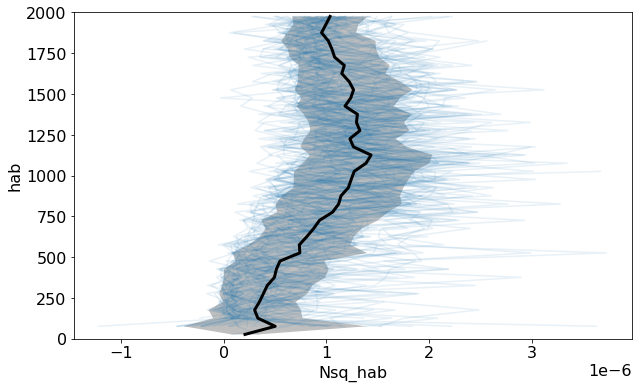

In [13]:
for i in mds["CAST"].values: mds['Nsq_hab'].sel(CAST=i).plot(y="hab", linestyle="-", color="C0", alpha=0.1)
mds_av = mds['Nsq_hab'].mean("CAST", skipna=True)
mds_std = mds['Nsq_hab'].std("CAST", skipna=True)

mds_av.plot(y="hab", linestyle="-", color="k", lw=3.)
plt.fill_betweenx(mds["hab"], mds_av-mds_std, mds_av+mds_std, facecolor="k", alpha=0.25)
plt.ylim([0, 2000])

# Map of hydrographic and microstructure profiles

Colored by whether Thurnherr classified as "in-canyon".

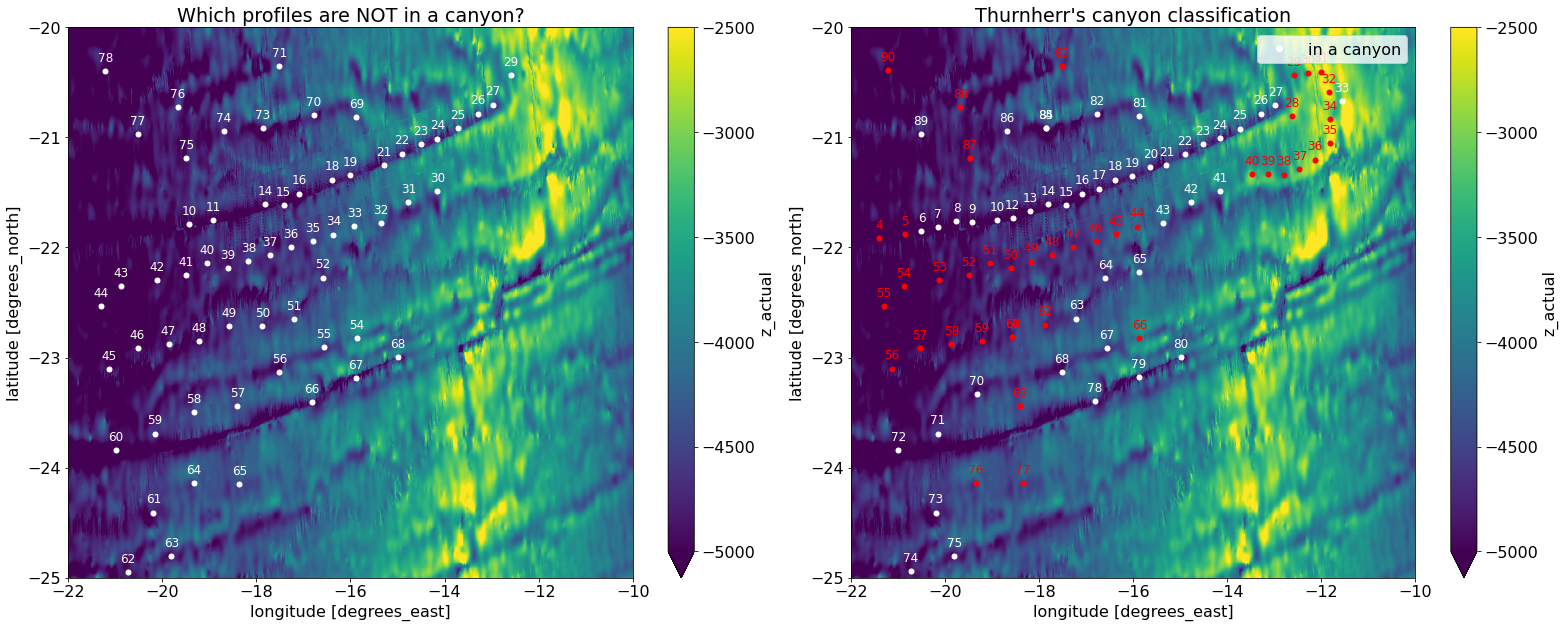

In [14]:
plt.figure(figsize=(22,9))
ax = plt.subplot(1,2,1)
q = bathy['z'].sel(lon=slice(-22, -10), lat=slice(-25, -20)).plot(ax=ax,x='lon', y='lat', vmin=-5000, vmax=-2500)
q.colorbar.remove()
geo_XY['z_actual'].plot(ax=ax, x='lon', y='lat', vmin=-5000, vmax=-2500)
for num in np.unique(cdf['cast number']):
    cast = cdf[cdf['cast number']==num].iloc[0]
    if cdf[cdf['cast number']==num].iloc[0]['latitude'].dtype == 'float64':
        x = cast['longitude']
        y = cast['latitude']
        ax.plot(x, y, color="w", marker="o", markersize=5)
        ax.annotate(num, # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             fontsize=12,
             color='w',
             ha='center'
        )
plt.title("Which profiles are NOT in a canyon?")
plt.tight_layout()

ax = plt.subplot(1,2,2)
q = bathy['z'].sel(lon=slice(-22, -10), lat=slice(-25, -20)).plot(ax=ax,x='lon', y='lat', vmin=-5000, vmax=-2500)
q.colorbar.remove()
geo_XY['z_actual'].plot(ax=ax, x='lon', y='lat', vmin=-5000, vmax=-2500)
for num in np.unique(ndf['castnum']):
    cast = ndf[ndf['castnum']==num].iloc[0]
    if cast['latitude'].dtype == 'float64':
        x = cast['longitude']
        y = cast['latitude']
        if (x<-22) | (x>-10) | (y>-20) | (y<-25): continue
        col='w'
        if np.isnan(cast['canyon']): col='r'
        ax.plot(x, y, color=col, marker="o", markersize=5)
        ax.annotate(np.int(num), # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             fontsize=12,
             color=col,
             ha='center'
        )
plt.plot([],[], "wo", label="in a canyon")
plt.title("Thurnherr's canyon classification")
plt.legend()
plt.tight_layout()

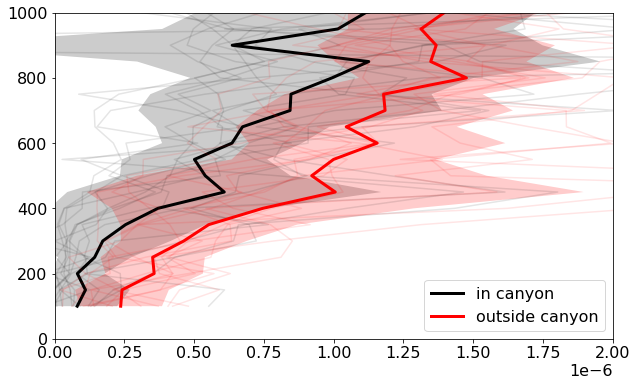

In [15]:
in_list = np.arange(10,28)
out_list = np.arange(33,45)

nz = 60
in_arr = np.ones((nz, len(in_list)))*np.nan
for i, num in enumerate(in_list):
    if num in cdf['cast number']:
        tmp_df = cdf[cdf['cast number']==num]
        if len(tmp_df)>0:
            plt.plot(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], "k-", alpha=0.1)
            plt.ylim([0, 1000])
            in_arr[:, i] = tmp_df['Nsq']
plt.fill_betweenx(-tmp_df['pressure_f above bottom'], np.nanmean(in_arr,axis=1) - np.nanstd(in_arr,axis=1), np.nanmean(in_arr,axis=1) + np.nanstd(in_arr,axis=1), facecolor="k", alpha=0.2)
plt.plot(np.nanmean(in_arr,axis=1), -tmp_df['pressure_f above bottom'], "k-", lw=3, label="in canyon")

out_arr = np.ones((nz, len(out_list)))*np.nan
for i, num in enumerate(out_list):
    if num in cdf['cast number']:
        tmp_df = cdf[cdf['cast number']==num]
        if len(tmp_df)>0:
            plt.plot(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], "r-", alpha=0.1)
            plt.ylim([0, 1000])
            out_arr[:, i] = tmp_df['Nsq']
            
plt.fill_betweenx(-tmp_df['pressure_f above bottom'], np.nanmean(out_arr,axis=1) - np.nanstd(out_arr,axis=1), np.nanmean(out_arr,axis=1) + np.nanstd(out_arr,axis=1), facecolor="r", alpha=0.2)
plt.plot(np.nanmean(out_arr,axis=1), -tmp_df['pressure_f above bottom'], "r-", lw=3, label="outside canyon")
plt.xlim([0, 2e-6])
plt.legend()

In [16]:
casts = cdf['cast number'].unique()

lons, lats = [], []
for cast in casts:
    lons.append(cdf[cdf['cast number']==cast]['longitude'].values[0])
    lats.append(cdf[cdf['cast number']==cast]['latitude'].values[0])

In [17]:
def global_argmin(da):
    xmin = da.min(dim=['Xr'])
    xargmin = da.argmin(dim='Xr').values
    yargmin = xmin.argmin(dim='Yr').values
    return [xargmin[yargmin], yargmin], xmin[yargmin].values

In [18]:
sample_locs = []
sample_casts = []
sample_coords = []
for c, cast in enumerate(casts):
    if np.isnan(lats[c]) | np.isnan(lons[c]): continue
    mindist = ((geo_XY['lat']-lats[c])**2 + (geo_XY['lon']-lons[c])**2)
    argmin, _ = global_argmin(mindist)
    if (
        (argmin[0] == 0) | (argmin[0] == geo_XY.dims['Xr']-1) |
        (argmin[1] == 0) | (argmin[1] == geo_XY.dims['Yr']-1)
    ):
        #print(f"Cast {cast} is outside domain")
        continue
    sample_locs.append(argmin)
    sample_coords.append([lons[c], lats[c]])
    sample_casts.append(cast)

0, 1, 2, 3, 4, 5, 6, 7, 8, 

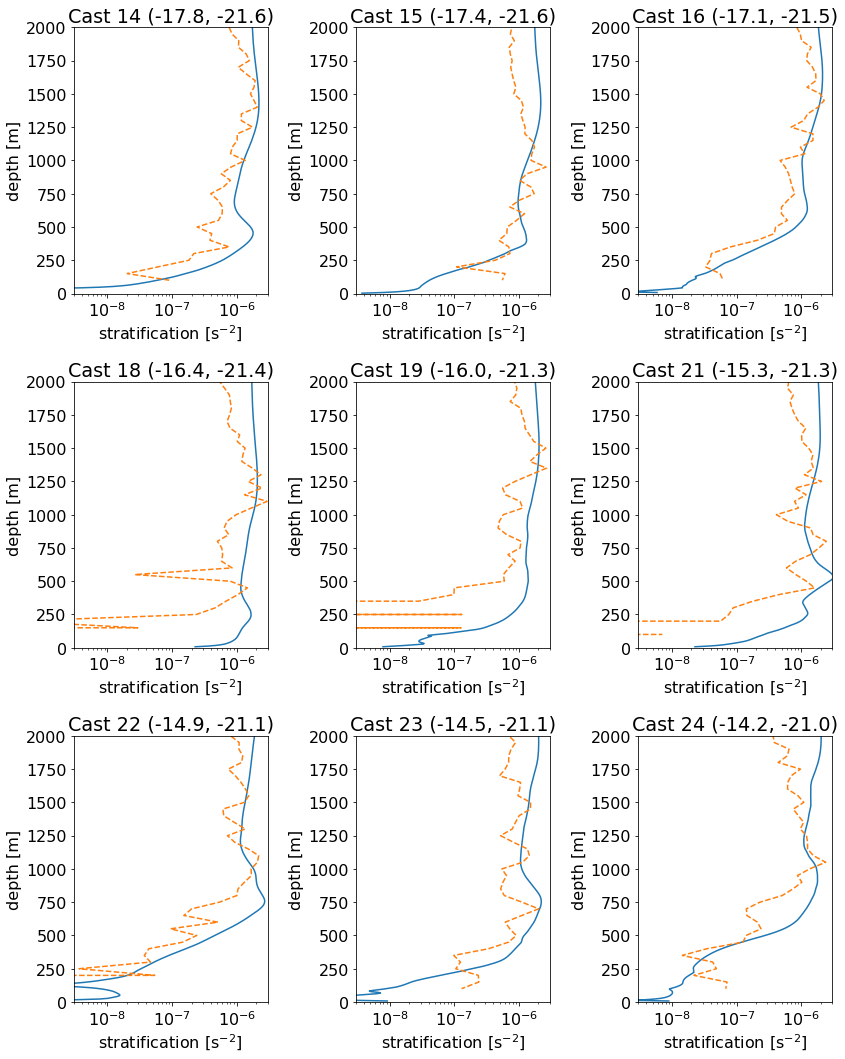

In [19]:
ds['TopographicHeight'] = ds.attrs['H']-ds['Depth']

plt.figure(figsize=(12, 15))

z_obs = -cdf[cdf['cast number']==sample_casts[0]]['pressure_f above bottom'].values
Nsq_obs_av = np.zeros(z_obs.size)

z_sim = ds['habC'].values
Nsq_sim_av = np.zeros(ds['habC'].size)

Nsamples = len(sample_casts)

for c, loc in enumerate(sample_locs):
    print(c, end=", ")
    plt.subplot(3,3,c+1)
    
    tmp = ds.isel(XC=loc[0], YC=loc[1])
    Nsq_sim_av += tmp['Nsq_hab'].values/Nsamples
    
    plt.semilogx(tmp['Nsq_hab'], tmp['habC'])
    
    tmp_df = cdf[cdf['cast number']==sample_casts[c]]
    Nsq_obs_av += tmp_df['Nsq'].values/Nsamples
    
    plt.semilogx(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], '--')
    plt.ylim([0, 2000])
    plt.title(f"Cast {sample_casts[c]} ({round(sample_coords[c][0],1)}, {round(sample_coords[c][1],1)})")
    plt.xlim([3.e-9,3.e-6])
    plt.xlabel(r"stratification [s$^{-2}$]")
    plt.ylabel("depth [m]")
    
plt.tight_layout()
plt.savefig("../../figures/BBTRE/canyon_casts_comparison.png", dpi=150, bbox_inches="tight")

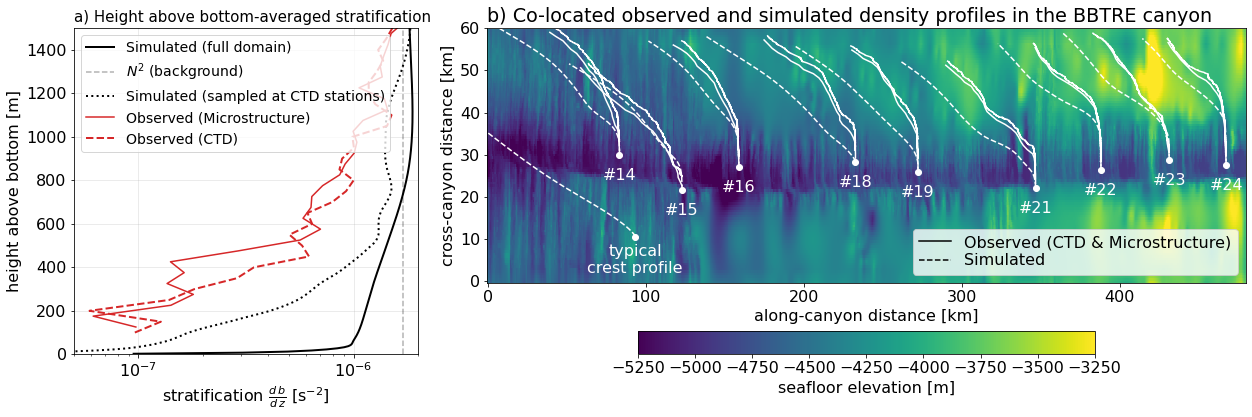

In [20]:
mds_av = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).mean("CAST", skipna=True)
mask_points = (np.isnan(mds['Nsq_hab'].sel(CAST=np.arange(13, 25))).mean('CAST')) <= 0.5
mds_av = mds_av.where(mask_points)

fig = plt.figure(figsize=(21.,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])

ds['Nsq_hab_av'].plot(y="habC", xscale="log", lw=2., color="k", linestyle="-", label="Simulated (full domain)")

plt.axvline(N**2, alpha=0.3, linestyle="--", color="k", label=r"$N^{2}$ (background)")
plt.grid(True, alpha=0.3)

plt.semilogx(Nsq_sim_av, z_sim, "k:", lw=2., label="Simulated (sampled at CTD stations)")
mds_av.plot(y='hab', color='C3', label="Observed (Microstructure)")
plt.semilogx(Nsq_obs_av, z_obs, "C3", lw=2., linestyle='--', label="Observed (CTD)")
plt.xlim([5e-8, 2e-6])
plt.ylim([0, 1500])
plt.xlabel(r"stratification $\frac{d\,b}{d\,z}$ [s$^{-2}$]")
plt.ylabel("height above bottom [m]")
plt.legend(loc="upper left", fontsize=14)
plt.title("a) Height above bottom-averaged stratification", fontsize=15, loc="left")

ax2 = fig.add_subplot(gs[0, 1:])
PC = (geo_XY['z_actual']).plot(cbar_kwargs={'label':"seafloor elevation [m]", "orientation":"horizontal", "fraction":0.07})
PC.set_clim([-5250, -3250])
for c, loc in enumerate(sample_locs):
    x = geo_XY['Xr'].isel(Xr=loc[0]).values
    y = geo_XY['Yr'].isel(Yr=loc[1]).values
    plt.plot(x, y, "wo")
    label = f"#{sample_casts[c]}"
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 color='w',
                 ha='center')
    
    # Observed profiles (MICROSTRUCTURE)
    X = mds['σ4'].sel(CAST=sample_casts[c])
    X = (X - X.max(skipna=True))*400e3

    Y = (X.BOT_DEPTH - X.DEPTH)
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w')
    
    # Observed profiles (CTD)
    tmp = cdf[cdf['cast number']==sample_casts[c]]
    X = tmp['sigma4']
    X = (X - X.max(skipna=True))*400e3

    Y = -tmp['pressure above bottom']
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w')
    
    # Simulated profiles
    X = (ρ0*(1-α*ds.isel(XC=loc[0], YC=loc[1])['THETA_BG_hab']))
    X = (X - X.max(skipna=True))*400e3

    Y = X.habC
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w--')
    
    
# Outside of canyon example
i=155; j=17;
x = ds['XC'].isel(XC=i).values
y = ds['YC'].isel(YC=j).values
plt.plot(x, y, "wo")
label = f"typical\ncrest profile"
plt.annotate(label, # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,-36), # distance from text to points (x,y)
             color='w',
             ha='center')

X = (ρ0*(1-α*ds.isel(XC=i, YC=j)['THETA_BG_hab']))
X = (X - X.max(skipna=True))*400e3

Y = X.habC
X = X.where(Y<1500.)
Y = Y*2e1
plt.plot(X+x,Y+y, 'w--')

plt.plot([], [], "k-", label="Observed (CTD & Microstructure)")
plt.plot([], [], "k--", label="Simulated")
plt.legend(loc="bottom right", labelspacing=0.2)
plt.title("b) Co-located observed and simulated density profiles in the BBTRE canyon", loc="left")

plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
xticks = np.arange(0., 500., 100.)
plt.xticks(xticks*1e3, np.int64(xticks))
yticks = np.arange(0., 70., 10.)
plt.yticks(yticks*1e3, np.int64(yticks))

plt.savefig("../../figures/BBTRE/stratification_comparison.png", dpi=150, bbox_inches="tight")